In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn import preprocessing
from sklearn.model_selection import *
from models import *
from scipy.signal import lfilter

## **Exploratory Data Analysis**

In [2]:
data = pickle.load(open(r'../Data/sev_deltaQ_cycles.pkl', 'rb'))
#data2 = pickle.load(open(r'../Data/temp_features.pkl', 'rb'))

print(data['b1c1'].keys())

dict_keys(['cycle_life', 'DeltaQ_logVars', 'DeltaQ_mins', 'DeltaQ_means', 'DeltaT_max', 'DeltaT_logVars', 'DeltaIR'])


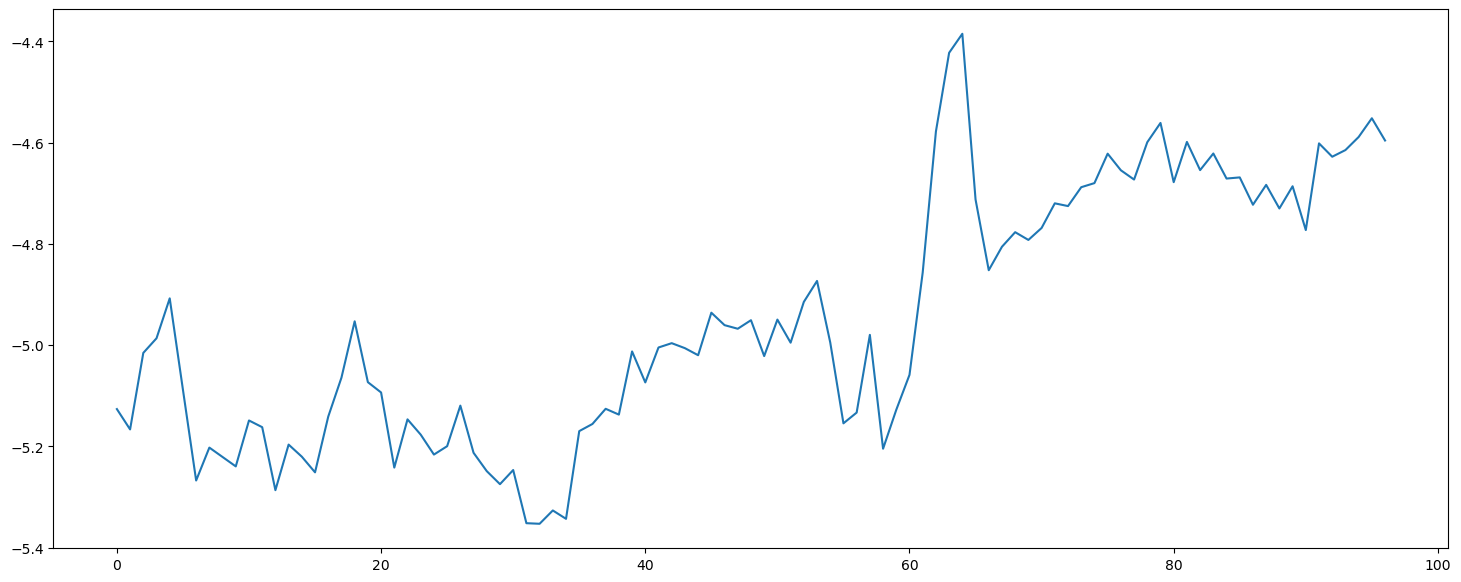

In [54]:
n_cycles = 98
cut_start = 1

features = [
    "DeltaQ_logVars",
    #"DeltaQ_mins",
    #"DeltaQ_means",
    # "DeltaT_max",
    # "DeltaT_logVars",
]

n_cycles = n_cycles - cut_start
y = np.zeros(124)
x = np.zeros((124, n_cycles*len(features)))

for i, cell in enumerate(data.keys()):
    for j, feature in enumerate(features):
        x[i, j*n_cycles:(j+1)*n_cycles] = data[cell][feature][cut_start:]
    #charge_policies[i] = 1/(data[cell]["chargetime_policy"])
    y[i] = np.log10(data[cell]["cycle_life"])

# convert to tensors and concatenate features and labels
x = torch.Tensor(x)
y = torch.Tensor(y)

# scaler = preprocessing.StandardScaler().fit(x)
# x = torch.Tensor(scaler.transform(x))


plt.plot(x[3])

## **AutoEncoder: Dimensionality Reduction**

### **Train Test Split**

In [4]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123])


Stage 1:

Epoch 50/500,   	decoding loss: 0.03,    	prediction loss: 44636.96,  	reg_loss: 3.71
Epoch 100/500,   	decoding loss: 0.07,    	prediction loss: 26718.84,  	reg_loss: 3.47
Epoch 150/500,   	decoding loss: 0.04,    	prediction loss: 14117.33,  	reg_loss: 3.31
Epoch 200/500,   	decoding loss: 0.02,    	prediction loss: 0.08,  	reg_loss: 3.17
Epoch 250/500,   	decoding loss: 0.06,    	prediction loss: 16849.25,  	reg_loss: 3.07
Epoch 300/500,   	decoding loss: 0.01,    	prediction loss: 9090.12,  	reg_loss: 2.97
Epoch 350/500,   	decoding loss: 0.07,    	prediction loss: 29.30,  	reg_loss: 2.88
Epoch 400/500,   	decoding loss: 0.09,    	prediction loss: 27792.09,  	reg_loss: 2.79
Epoch 450/500,   	decoding loss: 0.08,    	prediction loss: 5113.79,  	reg_loss: 2.72
Epoch 500/500,   	decoding loss: 0.02,    	prediction loss: 14.70,  	reg_loss: 2.63

train 	 110.66749
test 	 117.581055
sec 	 285.5794


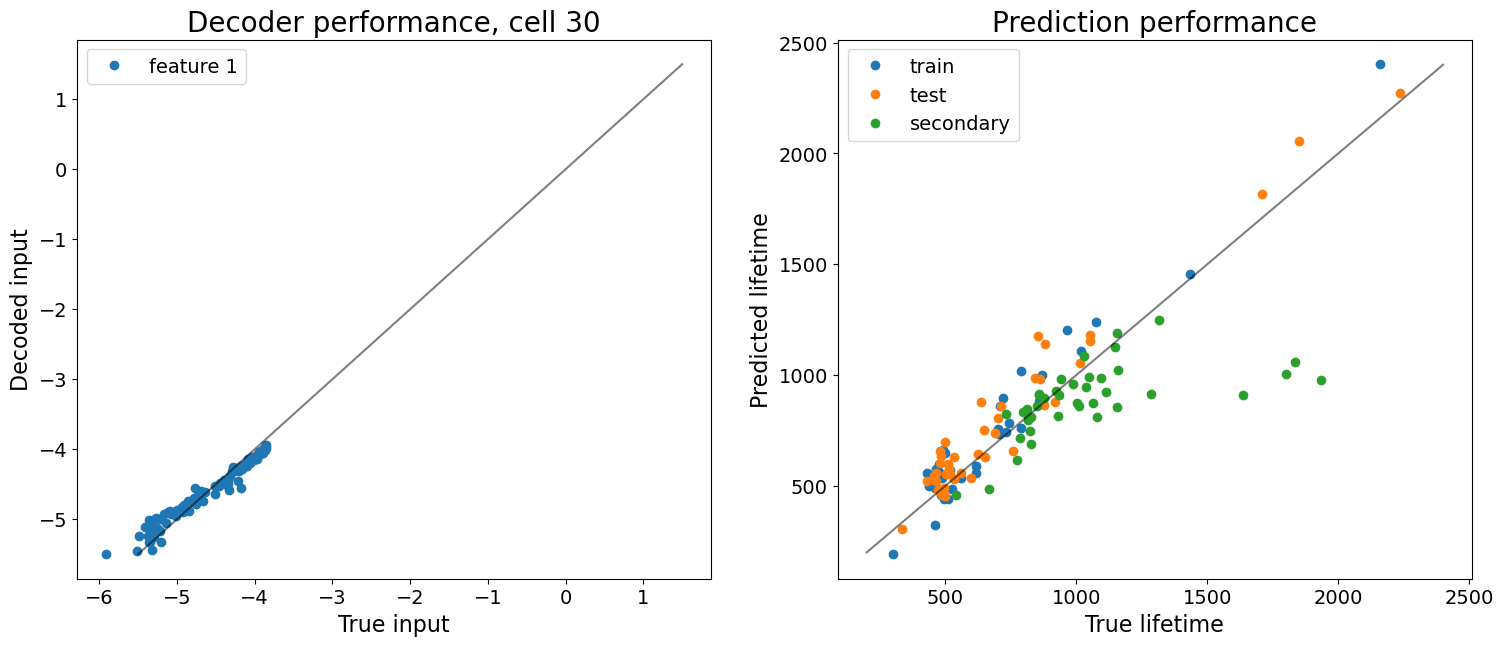

In [68]:
# FOR JUST LOGVAR FEATURE
train_policy = {
    "num_stages": 1,
    "epochs": [500],
    "learning_rates": [5e-4],
    "batch_sizes": [8],
    "prediction_weights": [1/1000],
    "decoding_weights": [10],
    "en_weights": [1]
}


model = AutoEncoder_Attention(n_features=len(features), n_cycles=n_cycles, attention_embedding=4)
#train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))
model.fit(x,y, train_policy)

Stage 1:

Epoch 250/2500,   	decoding loss: 0.18,    	prediction loss: 557808.75,  	reg_loss: 2.55
Epoch 500/2500,   	decoding loss: 0.09,    	prediction loss: 555181.19,  	reg_loss: 1.71
Epoch 750/2500,   	decoding loss: 0.07,    	prediction loss: 553330.75,  	reg_loss: 1.18
Epoch 1000/2500,   	decoding loss: 0.06,    	prediction loss: 550308.06,  	reg_loss: 0.72
Epoch 1250/2500,   	decoding loss: 0.05,    	prediction loss: 544961.38,  	reg_loss: 0.40
Epoch 1500/2500,   	decoding loss: 0.05,    	prediction loss: 535217.81,  	reg_loss: 0.19
Epoch 1750/2500,   	decoding loss: 0.05,    	prediction loss: 517105.94,  	reg_loss: 0.06
Epoch 2000/2500,   	decoding loss: 0.05,    	prediction loss: 465973.12,  	reg_loss: 0.05
Epoch 2250/2500,   	decoding loss: 0.05,    	prediction loss: 45148.47,  	reg_loss: 0.21
Epoch 2500/2500,   	decoding loss: 0.05,    	prediction loss: 8012.36,  	reg_loss: 0.15

train 	 85.34705
test 	 111.76651
sec 	 280.20233


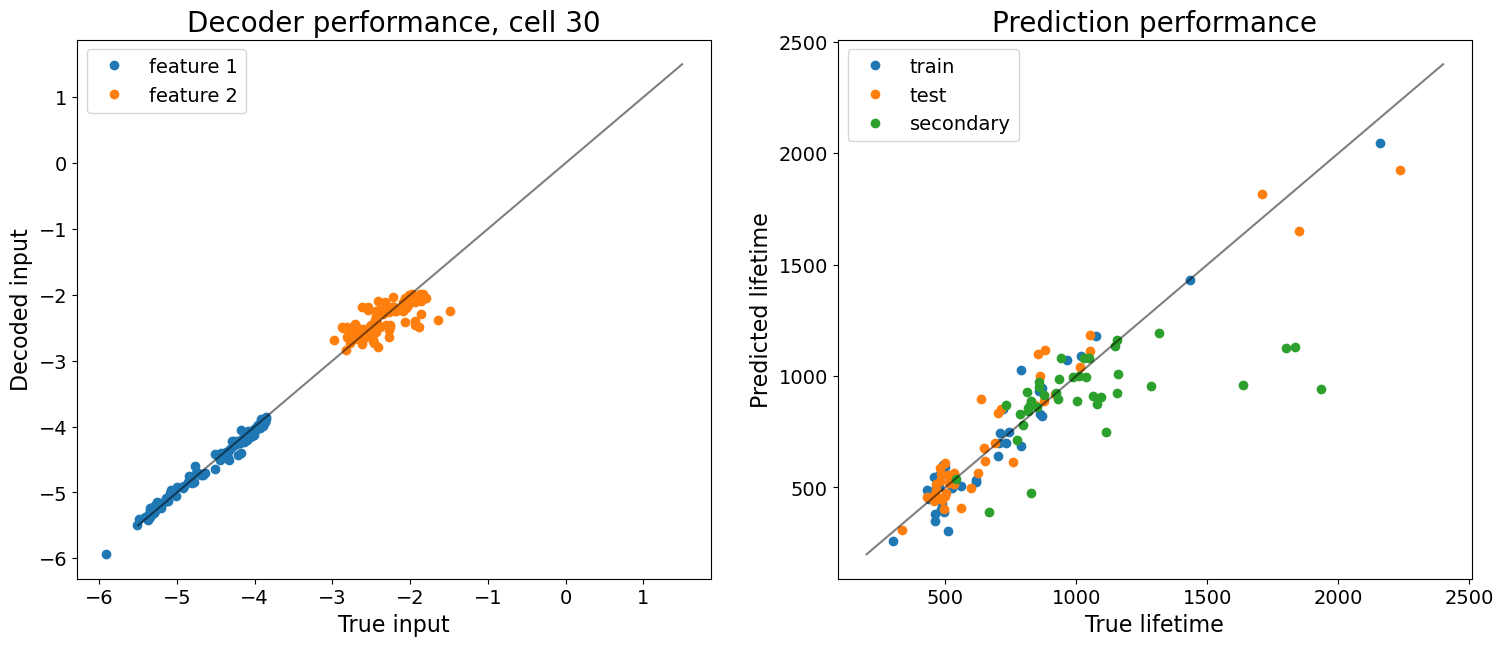

In [262]:
# ON DELTAQLOGVARS AND DELTATLOGVARS
train_policy = {
    "num_stages": 1,
    "epochs": [2500],
    "learning_rates": [5e-4],
    "batch_sizes": [64, 64],
    "prediction_weights": [1/5000],
    "decoding_weights": [50],
    "en_weights": [50]
}


model = AutoEncoder_Attention(n_features=len(features), n_cycles=n_cycles, attention_embedding=4)
#train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))
model.fit(x,y, train_policy)

Stage 1:

Epoch 20/200,   	decoding loss: 0.32,    	prediction loss: 616027.50,  	reg_loss: 1.68
Epoch 40/200,   	decoding loss: 0.05,    	prediction loss: 849.99,  	reg_loss: 1.34
Epoch 60/200,   	decoding loss: 0.30,    	prediction loss: 25510.26,  	reg_loss: 1.09
Epoch 80/200,   	decoding loss: 0.09,    	prediction loss: 2620.24,  	reg_loss: 0.88
Epoch 100/200,   	decoding loss: 0.06,    	prediction loss: 17726.60,  	reg_loss: 0.71
Epoch 120/200,   	decoding loss: 0.10,    	prediction loss: 940.50,  	reg_loss: 0.58
Epoch 140/200,   	decoding loss: 0.11,    	prediction loss: 16857.54,  	reg_loss: 0.48
Epoch 160/200,   	decoding loss: 0.10,    	prediction loss: 47.76,  	reg_loss: 0.39
Epoch 180/200,   	decoding loss: 0.03,    	prediction loss: 1470.23,  	reg_loss: 0.32
Epoch 200/200,   	decoding loss: 0.04,    	prediction loss: 6193.16,  	reg_loss: 0.26

train 	 89.35874
test 	 126.0318
sec 	 392.64444


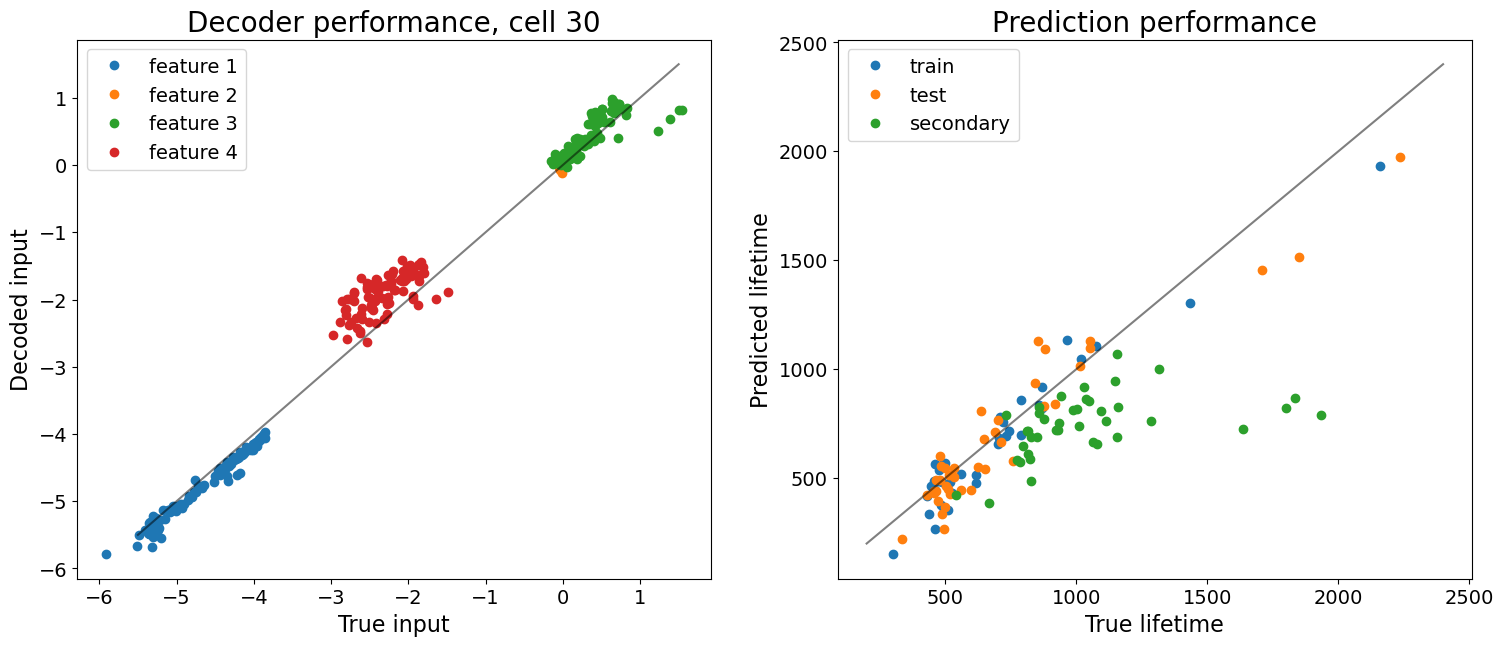

In [53]:
# ON 3 FEATURES
train_policy = {
    "num_stages": 1,
    "epochs": [200],
    "learning_rates": [1e-4],
    "batch_sizes": [8],
    "prediction_weights": [1/80000],
    "decoding_weights": [30],
    "en_weights": [2]
}


model = AutoEncoder_ElasticNet(n_features=len(features), n_cycles=n_cycles)
#train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))
model.fit(x,y, train_policy)

In [180]:
model.encoder(x[5])

tensor([ 0.0000, 11.6371,  0.0000,  0.0000,  0.0000,  0.7779,  2.3739,  0.0000,
         0.7495,  2.9191,  0.0000,  0.6527,  0.0000,  0.0000,  0.0000,  0.0000],
       grad_fn=<ReluBackward0>)

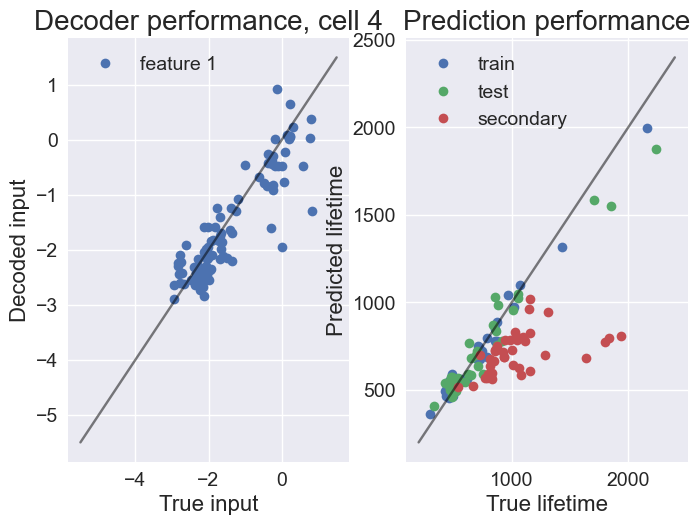

In [181]:
model.plotter(x, y, 4)

In [182]:
print(y[1], model.elastic_net_predict(x[1]))

tensor(3.3345) tensor([3.3001], grad_fn=<AddBackward0>)


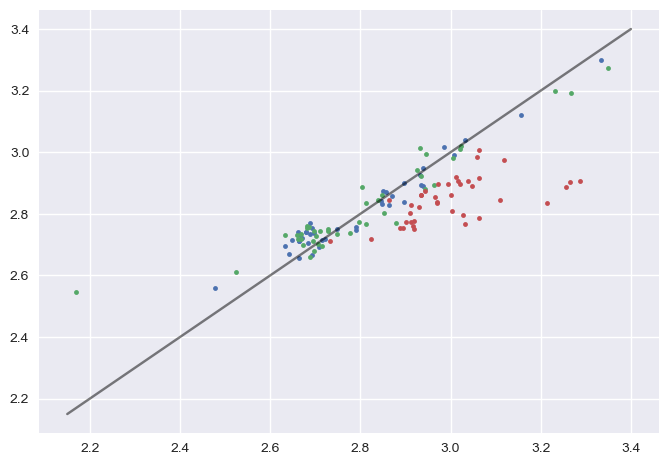

In [183]:
plt.plot(y[train_ind], model.elastic_net_predict(x[train_ind]).detach().numpy(), ".")
plt.plot(y[test_ind], model.elastic_net_predict(x[test_ind]).detach().numpy(), ".")
plt.plot(y[secondary_ind], model.elastic_net_predict(x[secondary_ind]).detach().numpy(), ".")
plt.plot(np.linspace(2.15, 3.4, 3), np.linspace(2.15, 3.4, 3), "k", alpha = 0.5)

# SVR

In [184]:
x_t = model.encoder(x[train_ind]).detach().numpy()
x_te = model.encoder(x[test_ind]).detach().numpy()
x_ste = model.encoder(x[secondary_ind]).detach().numpy()

print(x_t)

[[ 0.         23.987371    0.          0.          0.          0.6098015
   1.6507086   0.          3.4484096   0.06959954  0.          0.12747863
   0.          0.          0.          0.        ]
 [ 0.         15.428751    0.          0.          0.          0.7091011
   2.106847    0.          0.59931105  0.3201066   0.          0.5159663
   0.          0.          0.          0.        ]
 [ 0.         11.637114    0.          0.          0.          0.7779157
   2.373895    0.          0.7494678   2.9190507   0.          0.6526557
   0.          0.          0.          0.        ]
 [ 0.          6.5948606   0.          0.          0.          3.929205
   0.3535756   0.          0.3361352   1.7231987   0.          0.61473024
   0.          0.          0.          0.        ]
 [ 0.          4.718957    0.          0.          0.          0.
   1.0752627   0.          2.5727577   0.46401975  0.          0.5723152
   0.          0.          0.          0.        ]
 [ 0.          3.1952

In [185]:
# scaler = preprocessing.StandardScaler().fit(list(x_t))
# x_t = scaler.transform(list(x_t))
# x_te = scaler.transform(list(x_te))
# x_ste = scaler.transform(list(x_ste))

train = TensorDataset(torch.Tensor(x_t),torch.Tensor(y[train_ind]))
test = TensorDataset(torch.Tensor(x_te),torch.Tensor(y[test_ind]))
stest = TensorDataset(torch.Tensor(x_ste),torch.Tensor(y[secondary_ind]))

In [186]:
# parameters
lr = 0.001
feat_dim = 1*16
d_model = 2
nepoch = 2000
batch_size = 1

In [187]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [188]:
# Load nodel, loss function, and optimizer
model = AttentionModel2(feat_dim=1,d_model=d_model, n_cycle=feat_dim, skip_connect=0)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


model.train()

# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer.zero_grad()
        train_input, train_label = batch
        output = model(train_input.to(device))
        loss = criterion(10**output, 10**train_label)
        total_loss_train += loss.item()

        loss.backward()
        optimizer.step()

    for cell in test_batched:
        test_input, test_label = cell
        test_output = model(test_input.to(device))
        test_loss = criterion(10**test_output, 10**test_label)

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label = cell
        stest_output = model(stest_input.to(device))
        stest_loss = criterion(10**stest_output, 10**stest_label)
        

        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%50 == 0: 
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

#wandb.finish()

Epochs: 50 | rmse:  1094.675 | rmse_test:  2229.976 | rmse_stest:  1067.895
Epochs: 100 | rmse:  765.744 | rmse_test:  1271.165 | rmse_stest:  1069.192
Epochs: 150 | rmse:  701.119 | rmse_test:  984.775 | rmse_stest:  1069.932
Epochs: 200 | rmse:  689.143 | rmse_test:  886.671 | rmse_stest:  1070.366
Epochs: 250 | rmse:  685.992 | rmse_test:  863.651 | rmse_stest:  1070.489
Epochs: 300 | rmse:  676.979 | rmse_test:  861.563 | rmse_stest:  1070.400
Epochs: 350 | rmse:  661.405 | rmse_test:  847.242 | rmse_stest:  1070.056
Epochs: 400 | rmse:  647.334 | rmse_test:  778.460 | rmse_stest:  1069.647
Epochs: 450 | rmse:  665.827 | rmse_test:  751.278 | rmse_stest:  1069.160
Epochs: 500 | rmse:  671.958 | rmse_test:  752.471 | rmse_stest:  1068.408


KeyboardInterrupt: 

In [ ]:
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch

In [ ]:
fig,ax = plt.subplots()
colors = ["blue","red","orange"]
for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label = cell
        predicted.append(10**model(input[None,:].to(device)).detach().numpy()[0,0])
        labels.append(10**label)
    print(np.sqrt(np.mean(np.power(np.array(predicted)[:,0]-np.array(labels),2))))

    ax.plot(labels, predicted, ".",color=colors[i])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)
#plt.savefig("../images/transformer_output.png",dpi=300)